# **Sentiment Analysis of Yelp Reviews**

**Sentiment analysis** is the process of identifying and categorizing opinions expressed in a piece of text.  It uses Natural Language Processing (NLP), machine learning, and other data analysis techniques to identify and categorize these opinions.

**Yelp** is a business directory service and review site that allows users to give ratings and review businesses. The review is usually short text consisting of few lines with about hundred words.

In order to perform machine learning on text, we need to transform our text into vectors. This process is called **vectorization**.
To perform feature vectorization, we first need to tokezine the text.  **Tokenization** is the process of converting text into tokens before transforming it into vectors.  There are many ways to tokenize text, in this project, we will use `*CountVectorizer()*` and `TfidfTransformer()` from `scikit-learn` library.

`CountVectorizer()` it is used to transform a given text into a vector on the basis of the frequency count of each word that occurs in the entire text.
CountVectorizer does not take into account the context of the text. Another approach, to consider the relative frequency of tokens in the text against their frequency in the other texts, would be to use the *TfidfTransformer()*

`TfidfTransformer()` normalizes the frequency of tokens in a document with respect to the rest of the texts. This approach accentuates the tokens that are very relevant to a specific dataset.

### Import the required libraries

In [46]:
import warnings 
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import  TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lour2\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Import the dataset

In [5]:
!wget https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/classification-of-yelp-restaurant-reviews-using-sentiment-analysis/asset/sample_data.json

"wget" no se reconoce como un comando interno o externo,
programa o archivo por lotes ejecutable.


In [6]:
rev = pd.read_json('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/classification-of-yelp-restaurant-reviews-using-sentiment-analysis/asset/sample_data.json')
rev.head()

,index,review_id,user_id,business_id,stars,useful,funny,cool,text,date,year
0,4686059,aFz1itIWIl7Qojxhpa0VoQ,SsUKdScC6NKcnFFio75wMA,H1ifIm6P1TgCjxM-TOlgTw,1,1,1,0,Ok so now i go to see a movie and homeboy hand...,2016-11-19 20:40:09,2016
1,6762380,s_ba4NB2G2QWS3izLkvl5Q,q5zFh3bhuLy6u7CzYlsa8Q,3r3RHfuLPgRSiRkp5udXSw,5,0,0,0,"It wasn't my choice to eat breakfast here, but...",2019-09-02 17:40:35,2019
2,491263,K1I5yuJICQpInOy-wCCo9A,UqqqBhqlAHiHfB_V3BNmvw,ljGzs5MhfnH1pKfJjFFRlQ,5,0,0,0,The staff is very friendly and I really like D...,2017-06-25 01:27:59,2017
3,6662859,NOwHErM1-u4d8Z6vSS7FwA,cmHaLdW8ssAXK2MKZ2idmw,xoJSkBTusOEt8PPvuw2qEQ,1,0,2,0,I usually have a great experience here but lef...,2017-02-05 20:22:26,2017
4,7361472,JjvOoHUs-OrPEnuUUanDsw,dTSwfFTTHPHwSe48qDkPXg,wTBid_bYRigHAl6vNHYeOQ,5,4,1,1,UPDATE:\nI have been contacted shortly after t...,2016-03-03 17:59:40,2016


Let's look at the dataset size, features, and types by using the `shape` and `info()` functions.

In [7]:
print(rev.shape)
print(rev.info())

(86354, 11)
<class 'pandas.core.frame.DataFrame'>
Index: 86354 entries, 0 to 86353
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype         
---  ------       --------------  -----         
 0   index        86354 non-null  int64         
 1   review_id    86354 non-null  object        
 2   user_id      86354 non-null  object        
 3   business_id  86354 non-null  object        
 4   stars        86354 non-null  int64         
 5   useful       86354 non-null  int64         
 6   funny        86354 non-null  int64         
 7   cool         86354 non-null  int64         
 8   text         86354 non-null  object        
 9   date         86354 non-null  datetime64[ns]
 10  year         86354 non-null  int64         
dtypes: datetime64[ns](1), int64(6), object(4)
memory usage: 7.9+ MB
None


### **Data Exploratory Analysis**

Let's remove some of the columns that will not be used in our analysis and add a length of the text column

In [8]:
reviews = rev.drop(['index','date','year','business_id','review_id','user_id'], axis =1)
reviews

,stars,useful,funny,cool,text
0,1,1,1,0,Ok so now i go to see a movie and homeboy hand...
1,5,0,0,0,"It wasn't my choice to eat breakfast here, but..."
2,5,0,0,0,The staff is very friendly and I really like D...
3,1,0,2,0,I usually have a great experience here but lef...
4,5,4,1,1,UPDATE:\nI have been contacted shortly after t...
...,...,...,...,...,...
86349,4,0,0,0,When you want something healthy and feel like ...
86350,5,0,0,0,Awesome service. High class place. Great atmos...
86351,5,2,0,0,We have loved living at the Place on Ponce. Fr...
86352,4,24,1,4,Skyhouse Midtown opened in 2013 so its basical...


In [9]:
reviews['text length'] = rev['text'].apply(len)
reviews

,stars,useful,funny,cool,text,text length
0,1,1,1,0,Ok so now i go to see a movie and homeboy hand...,337
1,5,0,0,0,"It wasn't my choice to eat breakfast here, but...",308
2,5,0,0,0,The staff is very friendly and I really like D...,449
3,1,0,2,0,I usually have a great experience here but lef...,403
4,5,4,1,1,UPDATE:\nI have been contacted shortly after t...,1551
...,...,...,...,...,...,...
86349,4,0,0,0,When you want something healthy and feel like ...,425
86350,5,0,0,0,Awesome service. High class place. Great atmos...,130
86351,5,2,0,0,We have loved living at the Place on Ponce. Fr...,454
86352,4,24,1,4,Skyhouse Midtown opened in 2013 so its basical...,1613


Next, we will check if our data contains any null values.

In [10]:
reviews.isnull().sum()

stars          0
useful         0
funny          0
cool           0
text           0
text length    0
dtype: int64

We do not have any null values in our data.

Next, we will generate a count plot to display the distribution of stars in our dataset.

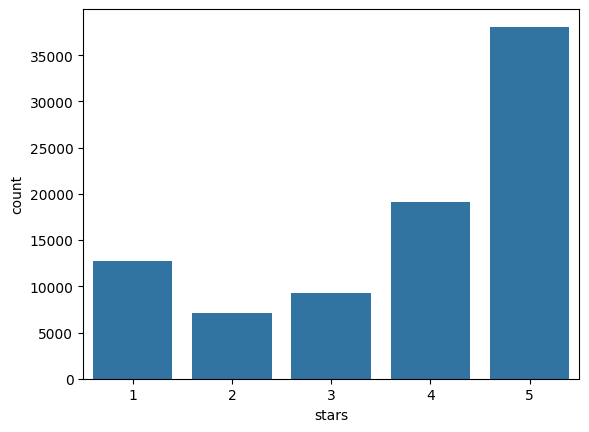

In [11]:
sns.countplot(x = 'stars', data = reviews);

Now, we will plot the distribution of the length of the reviews.

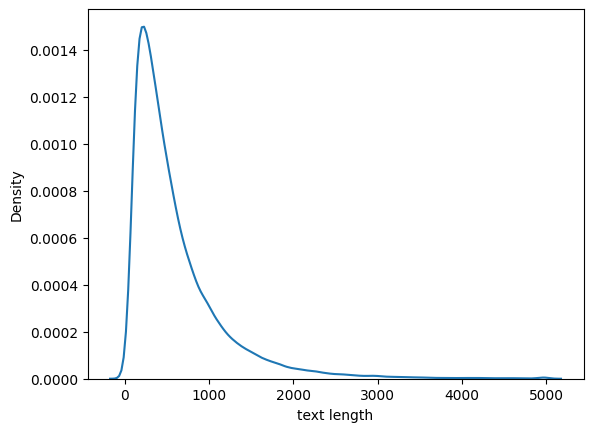

In [12]:
sns.kdeplot(x='text length', data = reviews);

In [13]:
print('The average number of words in the reviews is',reviews['text length'].mean())
print('The max number of words in the reviews is',reviews['text length'].max())
print('The min number of words in the reviews is',reviews['text length'].min())


The average number of words in the reviews is 609.3619056442087
The max number of words in the reviews is 5000
The min number of words in the reviews is 1


Next, we will select only 'stars' and 'text' columns for our analysis. These two columns provide all the necessary information for our analysis.

In [14]:
text = reviews[['stars','text']]
text.head()

,stars,text
0,1,Ok so now i go to see a movie and homeboy hand...
1,5,"It wasn't my choice to eat breakfast here, but..."
2,5,The staff is very friendly and I really like D...
3,1,I usually have a great experience here but lef...
4,5,UPDATE:\nI have been contacted shortly after t...


In the cells below, we are performing some text cleaning. We will do so by defining a function that can remove stopwords (words used in high repetitions, like prepositions and pronouns) and punctuation, convert to lower case, and keep only English reviews. After, we will make a copy of our 'cleaned' data to apply our function to.

In [15]:
cachedStopWords = stopwords.words("english")

def remove_stopwords_punct(text):
    remove_punc = [word for word in text.lower() if word not in string.punctuation]
    remove_punc = ''.join(remove_punc)
    return [word for word in remove_punc.split() if word not in cachedStopWords]
    
    

In [16]:
cleaned_text = text.copy()
cleaned_text['text'] = text['text'].apply(remove_stopwords_punct)

In [17]:
cleaned_text.head()

,stars,text
0,1,"[ok, go, see, movie, homeboy, hands, sheet, wa..."
1,5,"[wasnt, choice, eat, breakfast, boss, paying, ..."
2,5,"[staff, friendly, really, like, dr, hap, denta..."
3,1,"[usually, great, experience, left, extremely, ..."
4,5,"[update, contacted, shortly, review, email, tc..."


Now, to generate some insight from the reviews, we will generate the *frequency count* and *word cloud* plots.<br>
First, we will associate a 5-star reviews with a positive sentiment and 1-star reviews with a negative sentiment.
3-star reviews would be neutral, but for simplicity purposes, we will only attempt to predict the positive and negative sentiment, 3-star reviews are likely to contain both.

In [18]:
onestar = cleaned_text[cleaned_text['stars'] == 1].reset_index(drop=True)
fivestar = cleaned_text[cleaned_text['stars'] == 5].reset_index(drop=True)
def plot_freq(data):
    FreqDist(np.concatenate(data.text)).plot(20, cumulative=False)

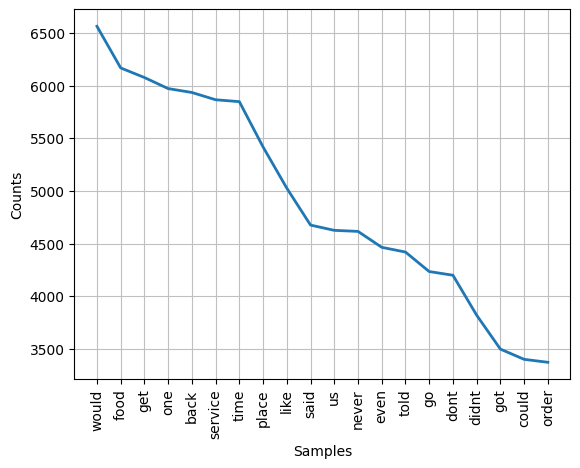

In [19]:
plot_freq(onestar)

Function to make a `WordCloud()` plot with most frequently used words in the **positive** or **negative** reviews.

In [20]:
def reviewCloud(star):
    startext = ' '.join(text[text['stars']==star]['text'])
    wordcloud = WordCloud(
        width = 3000,
        height = 2000,
        background_color = 'black',
        stopwords = STOPWORDS).generate(str(startext))

    fig = plt.figure(
        figsize = (10, 7),
        facecolor = 'k',
        edgecolor = 'k')
    plt.imshow(wordcloud, interpolation = 'bilinear')
    plt.axis('off')
    plt.tight_layout(pad=0)

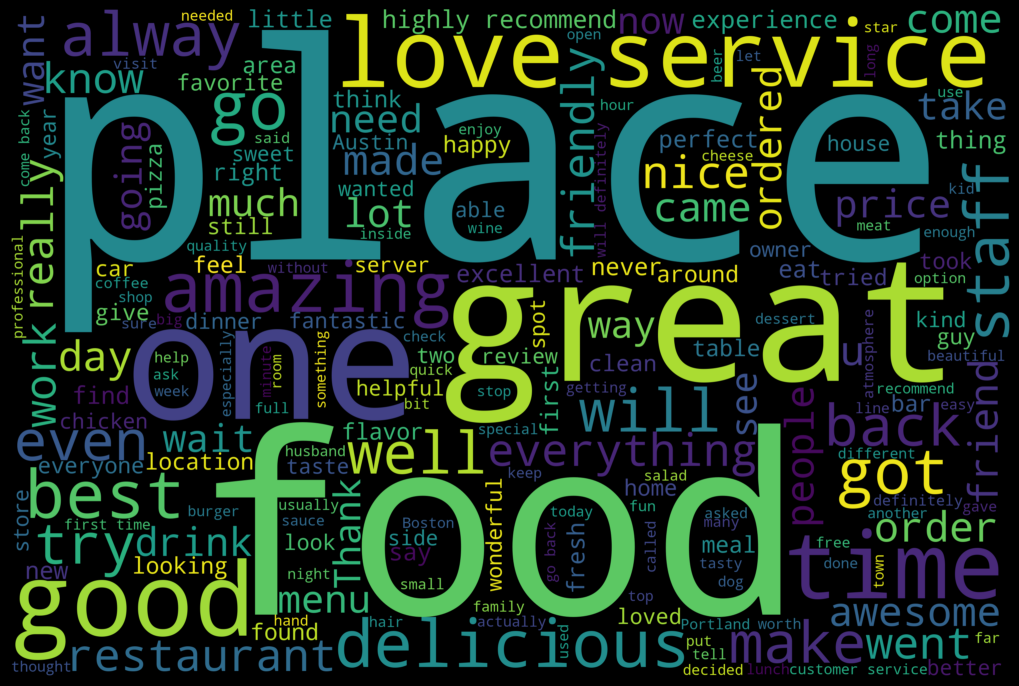

In [22]:
#positive reviews
reviewCloud(5)

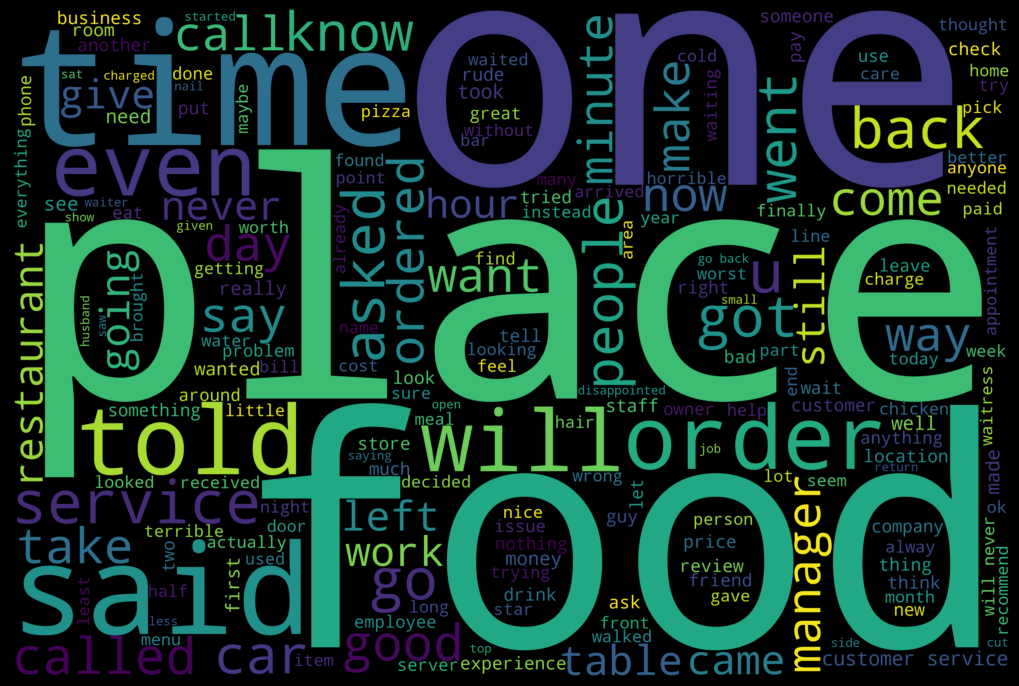

In [21]:
#negarive reviews
reviewCloud(1)

### **Model development**

Now let's build the model to classify our reviews into positive or negative. Let's separate the dataset into x and y variables.

In [44]:
training_text = text.loc[(cleaned_text['stars'] == 5) | (cleaned_text['stars'] == 1)]
x = training_text['text']
y = training_text['stars']

Before building a model, we need to transform our text into a matrix of token counts.<br>
1. First We will use `CountVectorizer()` to perform this task.<br>


In [45]:
count_vec = CountVectorizer().fit(x)
x = count_vec.transform(x)
print("Shape of the matrix: ", x.shape)

Shape of the matrix:  (50802, 57396)


Divide data into train and test

In [49]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In this classification problem, we will use the LogisticRegression() model for our classification task.

In [50]:
model = LogisticRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.95      0.92      0.94      2521
           5       0.97      0.98      0.98      7640

    accuracy                           0.97     10161
   macro avg       0.96      0.95      0.96     10161
weighted avg       0.97      0.97      0.97     10161



We are using precision, recall, and F1 score for our model evaluation. These are more appropriate performance metrics when dealing with the unbalanced data (our data is left-skewed, containing more '5' star reviews). As shown in this classification report, our model performs well on '1' and '5' star reviews, with 95% and 97% precision values respectively.

2. Now, we will try an alternative way to tokenize our text, by using the `TfidfTransformer()` transformer.

In [51]:
tfidf_transformer = TfidfTransformer().fit(x)
x_tfid = tfidf_transformer.transform(x)
print("Shape of the matrix: ", x.shape)

Shape of the matrix:  (50802, 57396)


Divide data into train and test again

In [52]:
x_train_tfid, x_test_tfid, y_train_tfid, y_test_tfid = train_test_split(x_tfid,y, test_size=0.2, random_state=42)

In [53]:
model = LogisticRegression()
model.fit(x_train_tfid, y_train_tfid)
y_pred_tfid = model.predict(x_test_tfid)
print(classification_report(y_test_tfid,y_pred_tfid))

              precision    recall  f1-score   support

           1       0.96      0.90      0.93      2521
           5       0.97      0.99      0.98      7640

    accuracy                           0.97     10161
   macro avg       0.96      0.94      0.95     10161
weighted avg       0.97      0.97      0.97     10161



The precision score has slightly improved for the '1' star reviews, increasing to 96%. However, the precision for '5' star reviews remains the same. TF-IDF Vectorizer does not make any significant improvement in our model performance. Although, it is more advanced way to vectorize the text data, in our case, it does not improve the overall precision.

Now, we can test our model to see whether it can predict '1' and '5' star ratings accurately

In [58]:
positive_review = text['text'][1]
print(positive_review)
print("Actual Rating: ",text['stars'][1])
pr_t = count_vec.transform([positive_review])
print("Predicted Rating:")
model.predict(pr_t)[0]

It wasn't my choice to eat breakfast here, but the boss was paying!
Very simple breakfast options and everything was done to perfection. 10 people in our group and everyone was happy with their food! The service was so perfect with the right amount of sarcasm!
The server did admit to doing open mic stand up
Actual Rating:  5
Predicted Rating:


5

In [59]:
negative_review = text['text'][3]
print(negative_review)
print("Actual Rating: ",text['stars'][3])
nr_t = count_vec.transform([negative_review])
print("Predicted Rating:")
model.predict(nr_t)[0]

I usually have a great experience here but left extremely disappointed today. I pulled in to the drive thru at 11:55 and they stop serving breakfast sandwiches at noon. I got to the window at 11:58 and they wouldn't sell me a sandwich. Then I still ordered a chai latte which was only 3/4 full. Won't be giving my business to them again, very disappointing since I've had great experiences before today.
Actual Rating:  1
Predicted Rating:


1

As we can see, the `LogisticRegression` model, in both cases, has accurately predicted the review rating score.